In [ ]:
import pandas as pd  
import plotly as plt
import matplotlib as mpl
import pandas as pd
import os
from pathlib import Path


In [8]:
import pandas as pd  
from pathlib import Path
import os
# Get project root directory (parent of notebooks directory)
if Path('config.yaml').exists():
    project_root = Path('.').resolve()
elif Path('../config.yaml').exists():
    project_root = Path('..').resolve()
else:
    # Try to find it by going up from current directory
    current = Path.cwd()
    while current != current.parent:
        if (current / 'config.yaml').exists():
            project_root = current.resolve()
            break
        current = current.parent
    else:
        project_root = Path('.').resolve()

# Change to project root for consistent paths
os.chdir(project_root)

# Get data directory
data_dir = project_root / 'data' / 'expression'

# Find all cleaned data files
# options from config.yaml:
# - GSE93606_cleaned.csv
# - GSE38958_cleaned.csv
# - GSE28042_cleaned.csv
# - GSE33566_cleaned.csv
data = list(data_dir.glob('*GSE28042_cleaned.csv'))
data = pd.read_csv(data[0])    
data.head(2)

C:\Users\User\AppData\Local\Temp\ipykernel_4372\262314871.py:33: DtypeWarning: Columns (18648) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data[0])


,sample_id,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAAS,...,survival_status,cell_type,time_to_outcomel,outcome,years_to_outcome,disease_status,time_to_survival,age,time_to_outcome,gender
0,GSM693754,6.686511,8.687128,4.816308,9.785831,4.668888,9.094248,2.480383,2.481340,9.730117,...,NaN,Peripheral blood mononuclear cells (PBMC),NaN,1.0,NaN,1,NaN,74,0.684 years,Male
1,GSM693807,7.131102,9.411876,4.176298,9.103864,6.334757,7.969104,3.471465,1.514857,9.625563,...,NaN,Peripheral blood mononuclear cells (PBMC),NaN,0.0,NaN,1,NaN,74,1.273 years,Female


In [ ]:
# Expression Level Analysis Pipeline

This pipeline performs comprehensive gene expression analysis including:
1. Data preparation and quality control
2. Differential expression analysis (disease vs control)
3. Statistical testing with multiple testing correction
4. Visualization (volcano plots, heatmaps)
5. Pathway enrichment analysis
6. Results export

In [ ]:
# Step 1: Data Preparation and Quality Control

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("Step 1: Data Preparation and Quality Control")
print("=" * 60)

# Ensure data is loaded
if 'data' not in globals():
    print("Loading data...")
    data_dir = Path('data/expression')
    data_files = list(data_dir.glob('*GSE28042_cleaned.csv'))
    if data_files:
        data = pd.read_csv(data_files[0], low_memory=False)
    else:
        raise FileNotFoundError("No cleaned data files found")

# Identify phenotype columns (non-gene columns)
phenotype_cols = ['sample_id', 'disease_status', 'age', 'gender', 'cell_type', 
                  'outcome', 'survival_status', 'time_to_outcome', 'years_to_outcome',
                  'time_to_survival', 'time_to_outcomel']

# Get actual phenotype columns that exist in data
phenotype_cols_present = [col for col in phenotype_cols if col in data.columns]

# Gene expression columns (everything else)
gene_cols = [col for col in data.columns if col not in phenotype_cols_present]

print("\nData Summary:")
print("  Total samples: %d" % len(data))
print("  Total columns: %d" % len(data.columns))
print("  Phenotype columns: %d" % len(phenotype_cols_present))
print("  Gene expression columns: %d" % len(gene_cols))

# Check disease status distribution
if 'disease_status' in data.columns:
    disease_counts = data['disease_status'].value_counts().sort_index()
    print("\nDisease Status Distribution:")
    for status, count in disease_counts.items():
        label = "Disease" if status == 1 else "Control" if status == 0 else "Unknown"
        print("  %s (%d): %d samples" % (label, status, count))
    
    # Check if we have enough samples for analysis
    if disease_counts.get(1, 0) < 3 or disease_counts.get(0, 0) < 3:
        print("\n⚠️  WARNING: Low sample size may affect statistical power")
    else:
        print("\n✅ Sample sizes adequate for analysis")
else:
    print("\n⚠️  WARNING: 'disease_status' column not found!")

# Separate expression and phenotype data
expression_data = data[gene_cols].copy()
phenotype_data = data[phenotype_cols_present].copy()

# Convert expression columns to numeric, coercing errors (non-numeric become NaN)
print("\nConverting expression data to numeric...")
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')

# Identify columns that are actually numeric (have numeric values)
numeric_cols = []
non_numeric_cols = []
for col in expression_data.columns:
    # Check if column has any numeric values
    if expression_data[col].notna().sum() > 0:
        # Check if values are actually numeric (not all NaN)
        sample_values = expression_data[col].dropna()
        if len(sample_values) > 0:
            numeric_cols.append(col)
        else:
            non_numeric_cols.append(col)
    else:
        non_numeric_cols.append(col)

if non_numeric_cols:
    print("  Removed %d non-numeric columns: %s..." % (len(non_numeric_cols), ', '.join(non_numeric_cols[:5])))
    expression_data = expression_data[numeric_cols]

print("  Numeric gene expression columns: %d" % len(numeric_cols))

# Basic QC: Check for missing values
missing_per_gene = expression_data.isnull().sum()
genes_with_missing = (missing_per_gene > 0).sum()
print("\nQuality Control:")
print("  Genes with missing values: %d (%.2f%%)" % (genes_with_missing, 
                                                      100 * genes_with_missing / len(numeric_cols)))

# Remove genes with >50% missing values
missing_threshold = 0.5 * len(expression_data)
genes_to_keep = missing_per_gene[missing_per_gene < missing_threshold].index
expression_data = expression_data[genes_to_keep]
print("  Genes retained after QC: %d" % len(genes_to_keep))
print("  Genes removed (>50%% missing): %d" % (len(numeric_cols) - len(genes_to_keep)))

# Log transform if needed (check if data is already log-transformed)
# Most microarray/RNA-seq data is already log-transformed
sample_values = expression_data.iloc[:, :10].values.flatten()
if sample_values.max() > 20:  # Likely not log-transformed
    print("\n⚠️  Data appears not log-transformed. Consider log2 transformation.")
else:
    print("\n✅ Data appears log-transformed (values < 20)")

print("\n" + "=" * 60)
print("Data preparation complete!")
print("=" * 60)


Step 1: Data Preparation and Quality Control

Data Summary:
  Total samples: 94
  Total columns: 18656
  Phenotype columns: 11
  Gene expression columns: 18645

Disease Status Distribution:
  Control (0): 19 samples
  Disease (1): 75 samples

✅ Sample sizes adequate for analysis

Quality Control:
  Genes with missing values: 0 (0.00%)
  Genes retained after QC: 18645
  Genes removed (>50% missing): 0

✅ Data appears log-transformed (values < 20)

Data preparation complete!


In [17]:
# Step 2: Differential Expression Analysis

from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("Step 2: Differential Expression Analysis")
print("=" * 60)

# Ensure we have disease_status
if 'disease_status' not in phenotype_data.columns:
    raise ValueError("disease_status column required for differential expression analysis")

# Separate disease and control groups
disease_mask = phenotype_data['disease_status'] == 1
control_mask = phenotype_data['disease_status'] == 0

disease_expr = expression_data[disease_mask]
control_expr = expression_data[control_mask]

print("\nGroup sizes:")
print("  Disease group: %d samples" % len(disease_expr))
print("  Control group: %d samples" % len(control_expr))

# Perform differential expression analysis for each gene
results = []

print("\nPerforming statistical tests for %d genes..." % len(expression_data.columns))

for gene in expression_data.columns:
    disease_values = disease_expr[gene].dropna()
    control_values = control_expr[gene].dropna()
    
    if len(disease_values) < 3 or len(control_values) < 3:
        # Skip if not enough data
        continue
    
    # Ensure values are numeric
    try:
        disease_values = pd.to_numeric(disease_values, errors='coerce').dropna()
        control_values = pd.to_numeric(control_values, errors='coerce').dropna()
    except:
        continue
    
    if len(disease_values) < 3 or len(control_values) < 3:
        continue
    
    # Calculate means
    disease_mean = disease_values.mean()
    control_mean = control_values.mean()
    
    # Skip if means are NaN
    if pd.isna(disease_mean) or pd.isna(control_mean):
        continue
    
    # Calculate fold change (log2 fold change if data is log-transformed)
    fold_change = disease_mean - control_mean  # Log2FC if log-transformed
    # If not log-transformed, use: fold_change = np.log2(disease_mean / control_mean)
    
    # Perform t-test
    try:
        t_stat, p_value = stats.ttest_ind(disease_values, control_values)
    except:
        p_value = np.nan
        t_stat = np.nan
    
    # Calculate effect size (Cohen's d)
    try:
        pooled_std = np.sqrt(((len(disease_values) - 1) * disease_values.std()**2 + 
                              (len(control_values) - 1) * control_values.std()**2) / 
                             (len(disease_values) + len(control_values) - 2))
        cohens_d = (disease_mean - control_mean) / pooled_std if pooled_std > 0 else 0
    except:
        cohens_d = 0
    
    results.append({
        'gene': gene,
        'disease_mean': disease_mean,
        'control_mean': control_mean,
        'fold_change': fold_change,
        'log2fc': fold_change,  # Assuming log-transformed
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'disease_n': len(disease_values),
        'control_n': len(control_values)
    })

# Convert to DataFrame
deg_results = pd.DataFrame(results)

# Multiple testing correction (FDR - Benjamini-Hochberg)
# Remove NaN p-values before correction
valid_p_values = deg_results['p_value'].notna()
deg_results.loc[valid_p_values, 'p_adjusted'] = multipletests(
    deg_results.loc[valid_p_values, 'p_value'], 
    method='fdr_bh'
)[1]
deg_results.loc[~valid_p_values, 'p_adjusted'] = np.nan

# Add significance labels
deg_results['significant'] = deg_results['p_adjusted'] < 0.05
deg_results['highly_significant'] = deg_results['p_adjusted'] < 0.01

# Sort by p-value
deg_results = deg_results.sort_values('p_adjusted')

print("\nDifferential Expression Results:")
print("  Total genes tested: %d" % len(deg_results))
print("  Significant genes (FDR < 0.05): %d" % deg_results['significant'].sum())
print("  Highly significant (FDR < 0.01): %d" % deg_results['highly_significant'].sum())

# Top up-regulated genes
upregulated = deg_results[deg_results['log2fc'] > 0].head(10)
print("\n  Top 10 Up-regulated genes (disease > control):")
for idx, row in upregulated.iterrows():
    print("    %s: log2FC=%.3f, p_adj=%.2e" % (row['gene'], row['log2fc'], row['p_adjusted']))

# Top down-regulated genes
downregulated = deg_results[deg_results['log2fc'] < 0].head(10)
print("\n  Top 10 Down-regulated genes (disease < control):")
for idx, row in downregulated.iterrows():
    print("    %s: log2FC=%.3f, p_adj=%.2e" % (row['gene'], row['log2fc'], row['p_adjusted']))

print("\n" + "=" * 60)
print("Differential expression analysis complete!")
print("=" * 60)


Step 2: Differential Expression Analysis

Group sizes:
  Disease group: 75 samples
  Control group: 19 samples

Performing statistical tests for 18645 genes...

Differential Expression Results:
  Total genes tested: 18618
  Significant genes (FDR < 0.05): 4997
  Highly significant (FDR < 0.01): 3077

  Top 10 Up-regulated genes (disease > control):
    LOC399900: log2FC=2.614, p_adj=1.45e-14
    FOS: log2FC=2.856, p_adj=2.52e-14
    JUN: log2FC=2.300, p_adj=4.23e-13
    RHOB: log2FC=1.724, p_adj=4.23e-13
    SRGN: log2FC=1.255, p_adj=5.27e-12
    ZBTB7B: log2FC=0.511, p_adj=1.82e-10
    DUSP1: log2FC=2.072, p_adj=2.07e-10
    NACC2: log2FC=0.963, p_adj=2.29e-10
    SOCS3: log2FC=1.974, p_adj=2.29e-10
    JUNB: log2FC=1.335, p_adj=2.32e-10

  Top 10 Down-regulated genes (disease < control):
    SPRYD5: log2FC=-2.566, p_adj=7.33e-13
    IL4: log2FC=-2.394, p_adj=1.17e-10
    TRIM53P: log2FC=-2.068, p_adj=2.59e-10
    ENPP3: log2FC=-1.670, p_adj=4.28e-10
    CPA3: log2FC=-2.255, p_adj=4.8

Step 3: Visualization - Volcano Plot


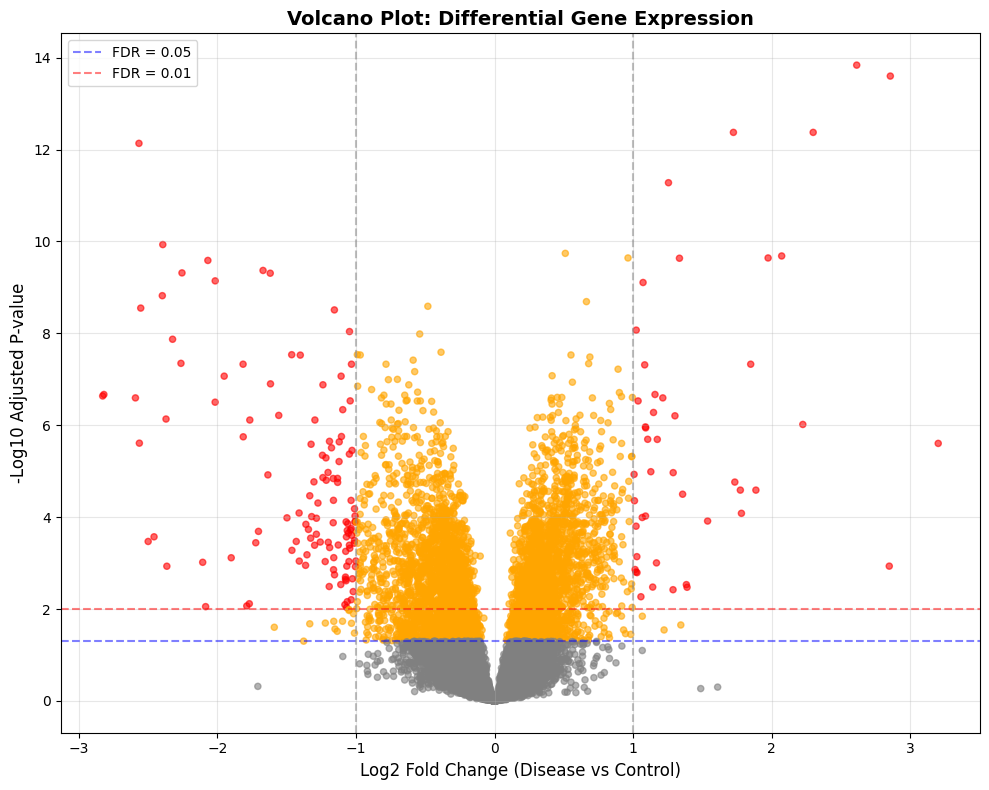


✅ Volcano plot created!
  Red points: Highly significant (FDR < 0.01) and |log2FC| > 1
  Orange points: Significant (FDR < 0.05)
  Gray points: Not significant



In [18]:
# Step 3: Visualization - Volcano Plot

print("=" * 60)
print("Step 3: Visualization - Volcano Plot")
print("=" * 60)

# Create volcano plot
fig, ax = plt.subplots(figsize=(10, 8))

# Color points based on significance
colors = []
for idx, row in deg_results.iterrows():
    if row['p_adjusted'] < 0.01 and abs(row['log2fc']) > 1:
        colors.append('red')  # Highly significant and large effect
    elif row['p_adjusted'] < 0.05:
        colors.append('orange')  # Significant
    else:
        colors.append('gray')  # Not significant

# Plot
ax.scatter(deg_results['log2fc'], -np.log10(deg_results['p_adjusted']), 
           c=colors, alpha=0.6, s=20)

# Add significance thresholds
ax.axhline(y=-np.log10(0.05), color='blue', linestyle='--', alpha=0.5, label='FDR = 0.05')
ax.axhline(y=-np.log10(0.01), color='red', linestyle='--', alpha=0.5, label='FDR = 0.01')
ax.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=-1, color='gray', linestyle='--', alpha=0.5)

# Labels and title
ax.set_xlabel('Log2 Fold Change (Disease vs Control)', fontsize=12)
ax.set_ylabel('-Log10 Adjusted P-value', fontsize=12)
ax.set_title('Volcano Plot: Differential Gene Expression', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Volcano plot created!")
print("  Red points: Highly significant (FDR < 0.01) and |log2FC| > 1")
print("  Orange points: Significant (FDR < 0.05)")
print("  Gray points: Not significant")
print("\n" + "=" * 60)


In [19]:
# Volcano Plot Interpretation and Summary

print("=" * 60)
print("Volcano Plot Interpretation")
print("=" * 60)

# Count genes in each category
if 'deg_results' in globals() and len(deg_results) > 0:
    # Define categories based on significance and fold change
    deg_results['category'] = 'Not Significant'
    
    # Highly significant with large effect
    highly_sig_large = (deg_results['p_adjusted'] < 0.01) & (abs(deg_results['log2fc']) > 1)
    deg_results.loc[highly_sig_large, 'category'] = 'Highly Significant + Large Effect'
    
    # Significant (FDR < 0.05)
    significant = (deg_results['p_adjusted'] < 0.05) & (~highly_sig_large)
    deg_results.loc[significant, 'category'] = 'Significant'
    
    # Count by category
    category_counts = deg_results['category'].value_counts()
    
    print("\nGene Categories:")
    print("=" * 60)
    for category, count in category_counts.items():
        percentage = 100 * count / len(deg_results)
        print("  %s: %d genes (%.2f%%)" % (category, count, percentage))
    
    # Up vs Down regulation
    highly_sig_genes = deg_results[highly_sig_large]
    if len(highly_sig_genes) > 0:
        upregulated = (highly_sig_genes['log2fc'] > 0).sum()
        downregulated = (highly_sig_genes['log2fc'] < 0).sum()
        
        print("\nHighly Significant Genes (FDR < 0.01, |log2FC| > 1):")
        print("=" * 60)
        print("  Up-regulated in disease: %d genes" % upregulated)
        print("  Down-regulated in disease: %d genes" % downregulated)
        
        # Top genes
        print("\n  Top 10 Up-regulated Genes:")
        top_up = highly_sig_genes[highly_sig_genes['log2fc'] > 0].nlargest(10, 'log2fc')
        for idx, row in top_up.iterrows():
            print("    %s: log2FC=%.3f, p_adj=%.2e" % (row['gene'], row['log2fc'], row['p_adjusted']))
        
        print("\n  Top 10 Down-regulated Genes:")
        top_down = highly_sig_genes[highly_sig_genes['log2fc'] < 0].nsmallest(10, 'log2fc')
        for idx, row in top_down.iterrows():
            print("    %s: log2FC=%.3f, p_adj=%.2e" % (row['gene'], row['log2fc'], row['p_adjusted']))
    
    print("\n" + "=" * 60)
    print("Interpretation:")
    print("=" * 60)
    print("\n1. RED POINTS (Upper Left & Right):")
    print("   - Highly significant (FDR < 0.01) AND large fold change (|log2FC| > 1)")
    print("   - These are your most important findings!")
    print("   - Upper RIGHT: Genes UP-regulated in IPF (disease > control)")
    print("   - Upper LEFT: Genes DOWN-regulated in IPF (disease < control)")
    print("   - These genes show both statistical and biological significance")
    
    print("\n2. ORANGE POINTS:")
    print("   - Statistically significant (FDR < 0.05)")
    print("   - May have smaller fold changes but still important")
    print("   - Worth investigating for pathway analysis")
    
    print("\n3. GREY POINTS (Center/Bottom):")
    print("   - Not statistically significant (FDR >= 0.05)")
    print("   - Or have small fold changes (|log2FC| < 1)")
    print("   - Less likely to be biologically relevant")
    
    print("\n4. BIOLOGICAL INTERPRETATION:")
    print("   - Log2FC > 1: Gene expression is >2x higher in disease")
    print("   - Log2FC < -1: Gene expression is >2x lower in disease")
    print("   - FDR < 0.01: Less than 1%% false discovery rate (very confident)")
    print("   - FDR < 0.05: Less than 5%% false discovery rate (standard threshold)")
    
    print("\n5. NEXT STEPS:")
    print("   - Focus on RED points for pathway enrichment")
    print("   - Investigate top up/down-regulated genes in literature")
    print("   - Check if these genes are known IPF-associated genes")
    print("   - Use for integration with published GWAS/eQTL results")
    
    print("\n" + "=" * 60)
else:
    print("Run the differential expression analysis first!")

print("=" * 60)


Volcano Plot Interpretation

Gene Categories:
  Not Significant: 13621 genes (73.16%)
  Significant: 4830 genes (25.94%)
  Highly Significant + Large Effect: 167 genes (0.90%)

Highly Significant Genes (FDR < 0.01, |log2FC| > 1):
  Up-regulated in disease: 47 genes
  Down-regulated in disease: 120 genes

  Top 10 Up-regulated Genes:
    G0S2: log2FC=3.202, p_adj=2.48e-06
    FOS: log2FC=2.856, p_adj=2.52e-14
    IL8: log2FC=2.849, p_adj=1.16e-03
    LOC399900: log2FC=2.614, p_adj=1.45e-14
    JUN: log2FC=2.300, p_adj=4.23e-13
    SLED1: log2FC=2.225, p_adj=9.61e-07
    DUSP1: log2FC=2.072, p_adj=2.07e-10
    SOCS3: log2FC=1.974, p_adj=2.29e-10
    NR4A2: log2FC=1.886, p_adj=2.58e-05
    FAM20A: log2FC=1.849, p_adj=4.70e-08

  Top 10 Down-regulated Genes:
    HBQ1: log2FC=-2.827, p_adj=2.31e-07
    HBA2: log2FC=-2.819, p_adj=2.14e-07
    CLC: log2FC=-2.591, p_adj=2.54e-07
    SPRYD5: log2FC=-2.566, p_adj=7.33e-13
    TRIM64: log2FC=-2.563, p_adj=2.46e-06
    MS4A2: log2FC=-2.553, p_adj=

Step 4: Heatmap of Top Differentially Expressed Genes


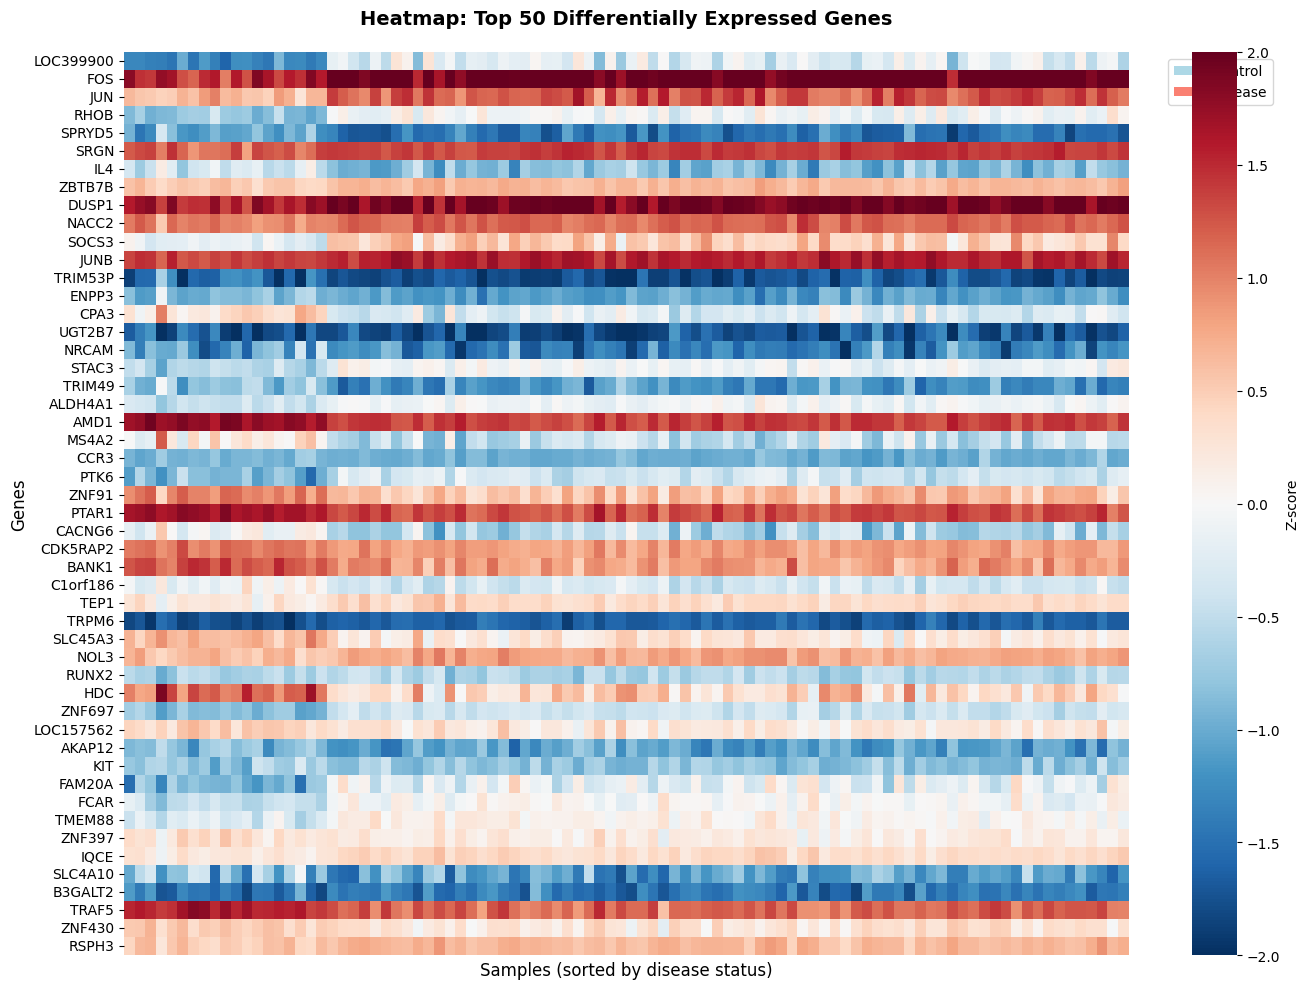


✅ Heatmap created!
  Showing top 50 most significant genes
  Red: Higher expression, Blue: Lower expression
  Samples sorted by disease status (Control → Disease)



In [20]:
# Step 4: Heatmap of Top Differentially Expressed Genes

print("=" * 60)
print("Step 4: Heatmap of Top Differentially Expressed Genes")
print("=" * 60)

# Get top N significant genes
top_n = 50
top_genes = deg_results.nsmallest(top_n, 'p_adjusted')['gene'].tolist()

# Prepare data for heatmap
heatmap_data = expression_data[top_genes].copy()

# Standardize (z-score) for better visualization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
heatmap_data_scaled = pd.DataFrame(
    scaler.fit_transform(heatmap_data.T).T,
    index=heatmap_data.index,
    columns=heatmap_data.columns
)

# Sort samples by disease status
sample_order = phenotype_data.sort_values('disease_status').index
heatmap_data_scaled = heatmap_data_scaled.loc[sample_order]

# Create annotation for disease status
disease_status_anno = phenotype_data.loc[sample_order, 'disease_status'].map({0: 'Control', 1: 'Disease'})

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 10))

# Create colormap for annotation
cmap_anno = {'Control': 'lightblue', 'Disease': 'salmon'}
row_colors = [cmap_anno[status] for status in disease_status_anno]

# Plot heatmap
sns.heatmap(heatmap_data_scaled.T, 
            cmap='RdBu_r', 
            center=0,
            vmin=-2, vmax=2,
            xticklabels=False,
            yticklabels=True,
            cbar_kws={'label': 'Z-score'},
            ax=ax)

ax.set_title('Heatmap: Top %d Differentially Expressed Genes' % top_n, 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Samples (sorted by disease status)', fontsize=12)
ax.set_ylabel('Genes', fontsize=12)

# Add color bar for disease status (simple version)
from matplotlib.patches import Rectangle
legend_elements = [Rectangle((0,0),1,1, facecolor='lightblue', label='Control'),
                   Rectangle((0,0),1,1, facecolor='salmon', label='Disease')]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

print("\n✅ Heatmap created!")
print("  Showing top %d most significant genes" % top_n)
print("  Red: Higher expression, Blue: Lower expression")
print("  Samples sorted by disease status (Control → Disease)")
print("\n" + "=" * 60)


In [21]:
# Step 5: Pathway Enrichment Analysis Preparation

print("=" * 60)
print("Step 5: Pathway Enrichment Analysis")
print("=" * 60)

# Get significant genes for pathway analysis
significant_genes = deg_results[deg_results['p_adjusted'] < 0.05]['gene'].tolist()
upregulated_genes = deg_results[(deg_results['p_adjusted'] < 0.05) & 
                                 (deg_results['log2fc'] > 0)]['gene'].tolist()
downregulated_genes = deg_results[(deg_results['p_adjusted'] < 0.05) & 
                                   (deg_results['log2fc'] < 0)]['gene'].tolist()

print("\nGenes for pathway analysis:")
print("  All significant genes: %d" % len(significant_genes))
print("  Up-regulated genes: %d" % len(upregulated_genes))
print("  Down-regulated genes: %d" % len(downregulated_genes))

# Prepare gene lists for enrichment tools
print("\n" + "=" * 60)
print("Pathway Enrichment Options:")
print("=" * 60)
print("\n1. GSEApy (Gene Set Enrichment Analysis)")
print("   Install: pip install gseapy")
print("   Use ranked gene list (by log2FC or -log10(p-value))")
print("\n2. Enrichr (Web-based)")
print("   Website: https://maayanlab.cloud/Enrichr/")
print("   Upload gene list: %s" % ', '.join(significant_genes[:10]) + "...")
print("\n3. DAVID (Web-based)")
print("   Website: https://david.ncifcrf.gov/")
print("   Upload gene list for functional annotation")
print("\n4. Reactome Pathway Analysis")
print("   Website: https://reactome.org/PathwayBrowser/")
print("   Use gene list for pathway over-representation")

# Create ranked gene list for GSEA
ranked_genes = deg_results.copy()
ranked_genes['rank_score'] = -np.log10(ranked_genes['p_adjusted']) * np.sign(ranked_genes['log2fc'])
ranked_genes = ranked_genes.sort_values('rank_score', ascending=False)

print("\n" + "=" * 60)
print("Ranked Gene List (for GSEA):")
print("=" * 60)
print("\nTop 20 genes by rank score:")
for idx, row in ranked_genes.head(20).iterrows():
    direction = "↑" if row['log2fc'] > 0 else "↓"
    print("  %s %s: rank_score=%.3f, log2FC=%.3f, p_adj=%.2e" % 
          (direction, row['gene'], row['rank_score'], row['log2fc'], row['p_adjusted']))

# Save gene lists for external tools
output_dir = Path('results')
output_dir.mkdir(exist_ok=True)

# Save significant genes
with open(output_dir / 'significant_genes.txt', 'w') as f:
    f.write('\n'.join(significant_genes))

# Save ranked list for GSEA
ranked_genes[['gene', 'rank_score']].to_csv(
    output_dir / 'ranked_genes_for_gsea.txt', 
    sep='\t', 
    index=False, 
    header=False
)

print("\n✅ Gene lists saved to 'results/' directory:")
print("  - significant_genes.txt (for Enrichr, DAVID)")
print("  - ranked_genes_for_gsea.txt (for GSEA)")

print("\n" + "=" * 60)
print("Pathway enrichment preparation complete!")
print("=" * 60)


Step 5: Pathway Enrichment Analysis

Genes for pathway analysis:
  All significant genes: 4997
  Up-regulated genes: 2401
  Down-regulated genes: 2596

Pathway Enrichment Options:

1. GSEApy (Gene Set Enrichment Analysis)
   Install: pip install gseapy
   Use ranked gene list (by log2FC or -log10(p-value))

2. Enrichr (Web-based)
   Website: https://maayanlab.cloud/Enrichr/
   Upload gene list: LOC399900, FOS, JUN, RHOB, SPRYD5, SRGN, IL4, ZBTB7B, DUSP1, NACC2...

3. DAVID (Web-based)
   Website: https://david.ncifcrf.gov/
   Upload gene list for functional annotation

4. Reactome Pathway Analysis
   Website: https://reactome.org/PathwayBrowser/
   Use gene list for pathway over-representation

Ranked Gene List (for GSEA):

Top 20 genes by rank score:
  ↑ LOC399900: rank_score=13.837, log2FC=2.614, p_adj=1.45e-14
  ↑ FOS: rank_score=13.599, log2FC=2.856, p_adj=2.52e-14
  ↑ JUN: rank_score=12.373, log2FC=2.300, p_adj=4.23e-13
  ↑ RHOB: rank_score=12.373, log2FC=1.724, p_adj=4.23e-13
  ↑

In [22]:
# Step 6: Results Summary and Export

print("=" * 60)
print("Step 6: Results Summary and Export")
print("=" * 60)

# Create comprehensive results summary
results_summary = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'GSE28042',
    'total_samples': len(data),
    'disease_samples': (phenotype_data['disease_status'] == 1).sum(),
    'control_samples': (phenotype_data['disease_status'] == 0).sum(),
    'total_genes_tested': len(deg_results),
    'significant_genes_fdr_05': deg_results['significant'].sum(),
    'significant_genes_fdr_01': deg_results['highly_significant'].sum(),
    'upregulated_genes': len(upregulated_genes),
    'downregulated_genes': len(downregulated_genes),
    'mean_fold_change': deg_results['log2fc'].mean(),
    'median_fold_change': deg_results['log2fc'].median()
}

print("\nAnalysis Summary:")
print("=" * 60)
for key, value in results_summary.items():
    print("  %s: %s" % (key.replace('_', ' ').title(), value))

# Export full results
output_dir = Path('results')
output_dir.mkdir(exist_ok=True)

# Save full DEG results
deg_results.to_csv(output_dir / 'differential_expression_results.csv', index=False)
print("\n✅ Full results saved: results/differential_expression_results.csv")

# Save significant genes only
significant_results = deg_results[deg_results['significant']].copy()
significant_results.to_csv(output_dir / 'significant_genes_results.csv', index=False)
print("✅ Significant genes saved: results/significant_genes_results.csv")

# Save summary statistics
summary_df = pd.DataFrame([results_summary])
summary_df.to_csv(output_dir / 'analysis_summary.csv', index=False)
print("✅ Summary saved: results/analysis_summary.csv")

print("\n" + "=" * 60)
print("Pipeline Complete!")
print("=" * 60)
print("\nNext Steps:")
print("1. Review significant genes in results/significant_genes_results.csv")
print("2. Perform pathway enrichment using saved gene lists")
print("3. Integrate with published GWAS/eQTL results")
print("4. Validate findings in independent datasets")
print("\n" + "=" * 60)


Step 6: Results Summary and Export

Analysis Summary:
  Analysis Date: 2025-12-24 14:09:22
  Dataset: GSE28042
  Total Samples: 94
  Disease Samples: 75
  Control Samples: 19
  Total Genes Tested: 18618
  Significant Genes Fdr 05: 4997
  Significant Genes Fdr 01: 3077
  Upregulated Genes: 2401
  Downregulated Genes: 2596
  Mean Fold Change: -0.022304429045796274
  Median Fold Change: -0.0036480127687719133

✅ Full results saved: results/differential_expression_results.csv
✅ Significant genes saved: results/significant_genes_results.csv
✅ Summary saved: results/analysis_summary.csv

Pipeline Complete!

Next Steps:
1. Review significant genes in results/significant_genes_results.csv
2. Perform pathway enrichment using saved gene lists
3. Integrate with published GWAS/eQTL results
4. Validate findings in independent datasets

